<a href="https://colab.research.google.com/github/njanrepo/MLEProject/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import math

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.3 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import yfinance as yf

### Get companies

In [4]:
def get_nyse_ticker_list():
  return load_nyse_csv()
  
def get_nyse_ticker_list_int():
  others_list = 'ftp://ftp.nasdaqtrader.com/symboldirectory/otherlisted.txt'
  ticker_df = pd.read_csv(others_list, sep='|')
  company_nyse = ticker_df[ticker_df['Exchange'] == 'N']
  return company_nyse['ACT Symbol'].values.tolist()

def get_sp500_list():
  payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  first_table = payload[0]
  sp500df = first_table
  sp500_list = sp500df.Symbol.values.tolist()
  return sp500_list

def load_nyse_csv():
  ticker_df = pd.read_csv('NYSE_SYMBOLS.csv')
  return ticker_df['Symbol'].values.tolist()

def load_sp500_csv():
  ticker_df = pd.read_csv('constituents_csv.csv')
  return ticker_df['Symbol'].values.tolist()

### Get historical data

In [5]:
def get_stock_data(type='SP500', limit=100):
  print("\nDownloading 6 months historical data for stock..")
  ticker_list = get_nyse_ticker_list() if type == 'NYSE' else load_sp500_csv()
  if(limit > len(ticker_list)):
    limit = len(ticker_list)
  ticker_data  = yf.download(ticker_list[0:limit], period='6mo', progress=False, group_by='symbol')
  #try:
   # ticker_data.drop('BF.B', axis=1, inplace=True)
    #ticker_data.drop('BRK.B', axis=1, inplace=True)
  #except:
   # print("its fine!!")
  ticker_data.dropna(how='all', axis=1, inplace=True)
  
  print(ticker_data.shape)
  #my_new_df = test_transposed.reset_index().dropna().set_index(old_idx)
  #new_dataset = my_new_df.T
  ticks = ticker_data.columns.get_level_values(0).unique().tolist()
  return (ticker_data, ticks)

In [7]:
x= get_stock_data(type='NYSE', limit=5)


(128, 30)


In [6]:
def ask_user(stocks = None):
  if(stocks != None):
    return stocks;
  how_many_stocks = input('How many stocks you want to analyse? \n Enter atleast 10 and max 500 \n')
  correct = False
  while not correct:
    try:
      how_many_stocks = int(how_many_stocks)
      if(how_many_stocks > 500 or how_many_stocks < 10):
        raise ValueError
      correct = True
    except:
      print("Please enter correct number 10 to 500")
      how_many_stocks = input('How many stocks you want to analyse? \n Enter atleast 10 and max 500 \n')
  return how_many_stocks    



#Calculate Market Capitalization


In [7]:
ticker='JPM'
def calc_market_capitalization(symbol):
  symbol_data = yf.download(symbol, period='1d', progress=True)
  if(len(symbol_data) == 0):
    return []
  m_dict = {}
  m_dict['symbol']=symbol
  m_dict['volume'] = symbol_data['Volume'][0]
  m_dict['close'] = symbol_data['Close'][0]
  m_dict['open'] = symbol_data['Open'][0]
  m_dict['market_cap'] = round((symbol_data['Volume'][0] * symbol_data['Close'][0]),2)
  return m_dict

def market_capitalization(type, limit):
  symbols =   get_nyse_ticker_list() if type == 'NYSE' else get_sp500_list()
  m_list = []
  if(limit > len(symbols)):
    limit = len(symbols)
  for symb in symbols[0:limit]:
    tmp = calc_market_capitalization(symb)
    if tmp:
      m_list.append(tmp)
  m_df = pd.DataFrame(m_list)
  return m_df

def get_top_market_stocks(type='SP500', limit=500):
  m_df = market_capitalization(type, limit)
  sorted = m_df.sort_values(by='market_cap', ascending=False)
  print(sorted.head())


In [9]:
x=calc_market_capitalization('TSLA')

[*********************100%***********************]  1 of 1 completed


## Predict Top Aggressive/Conservative stocks using regressor

In [10]:
#Regressor
#create feature and dependent variable for regression
def make_X_and_Y(close_prices, period):
  X = []
  y = []
  for i in range(len(close_prices)- period):
    X.append(close_prices[i:i+period])
    y.append(close_prices[i+period])
  return X,y

#create model with 200 n_estimators
def return_model(X, y):
  clf = RandomForestRegressor(n_estimators = 200)
  clf.fit(X,y)
  return clf
#clean data, drop Nan
def clean_data(data):
    return data.dropna(how='all', axis=0)
    
# test train split data
#X,y=make_X_and_Y(list(df.close))
#train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15 , shuffle=False,random_state = 0)
#Regression for predicting given stock symbol
def predict_price(symbol, period, data=None):
  print("\rAnalysing :: ", symbol, end="" )
  if(data is None):
    data = yf.download(symbol, period='6mo', progress=False, )
  data = clean_data(data)
  price = data.Close
  features, dep_var = make_X_and_Y(list(price), period)
  features = np.array(features)
  dep_var = np.array(dep_var)
  # Get Regression model
  clf=return_model(features, dep_var) 
  
  latest_feature = np.array(list(price)[-period:]).reshape((1,-1))
  s_dict = {}
  s_dict['symbol'] = symbol
  s_dict['volatility'] = round(price.std(), 2)
  s_dict['tomorrow'] = round(clf.predict(latest_feature)[0], 2)
  s_dict['today'] = round(price[-1],2)
  return s_dict

def prepare_recomm(data, how_many_stocks, period):
  if(data is None):
    print("No stock data found..")
    return
  stk_data = []
  list_of_symbols = data.columns.get_level_values(0).unique().tolist()
  if how_many_stocks > len(list_of_symbols):
    print("No. of stocks set to max")  
    how_many_stocks = len(data)
  for sym in list_of_symbols[0:how_many_stocks]:
    stk_data.append(predict_price(sym, period,data[sym]))
  print("\nAnalyzed "+str(len(stk_data)) + " stocks.." )
  return pd.DataFrame(stk_data)

 #return aggressive or conservative recommendations 
def get_recomm(s_data, ascending):
  cat = 'conservative' if ascending else 'aggressive'
  print("Top 5 " + cat +" stocks are.. ")
  tmp = s_data.sort_values(by='volatility', ascending=ascending)
  tmp = tmp[tmp['tomorrow'] > tmp['today']]
  return tmp.head() 

#Main Regressor
def regressor(how_many_stocks = None, period = None):
  if period == None:
    period = 6
  if how_many_stocks == None:
    how_many_stocks = ask_user()
  data_df, ticker_list = get_stock_data(type='NYSE', limit=how_many_stocks)
  pred_df = prepare_recomm(data_df, how_many_stocks, period)
  has_given_resp = False
  strategy = input("Enter Strategy : \n Enter 1 for Conservative\n Enter 2 for Aggresive\n")
  while not has_given_resp:
    if strategy == '1' or strategy.lower() == 'c' or strategy.lower() == 'conservative':
      has_given_resp = True
      print(get_recomm(pred_df, True))
    elif strategy == '2' or strategy.lower() == 'a' or strategy.lower() == 'aggresive':
      has_given_resp = True
      print(get_recomm(pred_df, False))
    else:
      print("Please enter correct number")
      strategy = input("Enter Strategy : \n Enter 1 for Conservative\n Enter 2 for Aggresive\n")

In [15]:
regressor()

How many stocks you want to analyse? 
 Enter atleast 10 and max 500 
10

(128, 60)
Analysing ::  HSC
Analyzed 10 stocks..
Enter Strategy : 
 Enter 1 for Conservative
 Enter 2 for Aggresive
1
Top 5 conservative stocks are.. 
  symbol  volatility  tomorrow  today
1    RZA        0.39     25.78  25.75
2    AHH        0.62     14.24  14.22
6   CANO        1.56      9.25   8.45
8   BRDG        1.81     20.40  19.99
0    TNL        3.62     50.89  49.42


## classification

In [39]:
def cl_make_X_and_Y(close_prices, period, in_future):
  X = []
  y = []
  for i in range(len(close_prices)- period-in_future):
    X.append(close_prices[i:i+period])
    l = close_prices[i+period:i+period+in_future]
    y.append(calculate_label(l))
  return X,y

def calculate_label(params):
  changes = []
  for j in range(len(params)-1):
    changes.append(params[j+1] - params[j]) 
  if changes[0] > 0:
    return 1;
  elif changes[0] <= 0:
     return -1;

def get_cl_model(model, X, y):
  #clf = DecisionTreeClassifier()
  model.fit(X,y)
  return model

def test_model(symbol):
  data = yf.download(symbol, period='6mo', progress=False, )
  data = data.dropna(how='all', axis=0)
  price = data.Close
  X, y = cl_make_X_and_Y(list(price), period, in_future)
  dfr = pd.DataFrame({'actual': X, 'predicted': y})
  train, test= train_test_split(dfr,test_size=0.15 , shuffle=False,random_state = 0)
  X_train = train['actual'].to_list()
  y_train = train['predicted'].to_list()
  X_test = train['actual'].to_list()
  y_test = train['predicted'].to_list()

def clean_data(data):
    return data.dropna(how='all', axis=0)


In [40]:
data = yf.download('AAPL', period='6mo', progress=False, )
data = data.dropna(how='all', axis=0)
price = data.Close
X, y = cl_make_X_and_Y(list(price), 6, 2)
dfr = pd.DataFrame({'actual': X, 'predicted': y})
train, test= train_test_split(dfr,test_size=0.15 , shuffle=False,random_state = 0)
X_train = train['actual'].to_list()
y_train = train['predicted'].to_list()
X_test = train['actual'].to_list()
y_test = train['predicted'].to_list()

KNN: 0.594545 (0.156046)
Score for each of the 10 K-fold tests:  [0.81818182 0.72727273 0.6        0.3        0.7        0.5
 0.5        0.5        0.5        0.8       ]
KNeighborsClassifier()
	Training time: 0.001s
	Prediction time: 0.024s
0.801364522417154

CART: 0.597273 (0.104451)
Score for each of the 10 K-fold tests:  [0.54545455 0.72727273 0.6        0.7        0.7        0.5
 0.6        0.4        0.5        0.7       ]
DecisionTreeClassifier()
	Training time: 0.001s
	Prediction time: 0.016s
1.0

RFC: 0.613636 (0.155996)
Score for each of the 10 K-fold tests:  [0.81818182 0.81818182 0.5        0.5        0.6        0.4
 0.8        0.6        0.4        0.7       ]
RandomForestClassifier()
	Training time: 0.147s
	Prediction time: 1.635s
1.0



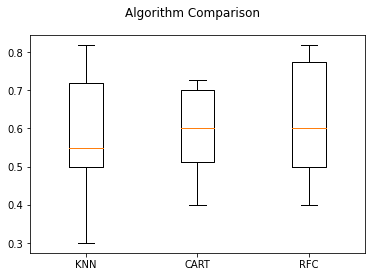

In [47]:
#Model Compare
# Compare Algorithms
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.metrics import classification_report
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
models = []
#models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))
#models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start = time()
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    model.fit(X_train, y_train)
    train_time = time() - start
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    predict_time = time()-start 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    y_pred = model.predict_proba(X_train)[:, 1]
    auc = roc_auc_score(y_train, y_pred)
    print(msg)
    print("Score for each of the 10 K-fold tests: ",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAUC: %0.3fs" % auc)
    #y_pred = model.predict(X_test)
    #print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print()
    
    
    
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

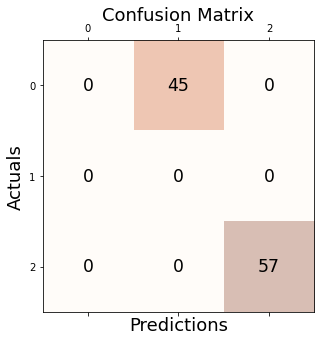

In [65]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

rf = DecisionTreeClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:, 1]
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [26]:
def classification_predict_price(symbol, period, in_future, data=None):
  print("\rAnalysing :: ", symbol, end="" )
  if(data is None):
    data = yf.download(symbol, period='6mo', progress=False, )
    data = clean_data(data)
  price = data.Close
  volume =data.Volume
  features, dep_var = cl_make_X_and_Y(list(price), period, in_future)
  features = np.array(features)
  dep_var = np.array(dep_var)
  # Get Classification model
  clf=get_cl_model(RandomForestClassifier(), features, dep_var) 
  
  latest_feature = np.array(list(price)[-period:]).reshape((1,-1))
  q=clf.predict(latest_feature)
  tomorrow = 'HOLD'
  if q[0] == 1:
    tomorrow = "BUY"
  elif q[0] == -1:
    tomorrow = "SELL"
  s_dict = {}
  s_dict['symbol'] = symbol
  s_dict['volatility'] = round(price.std(), 2)
  s_dict['tomorrow'] = tomorrow
  s_dict['price'] = round(price[-1],2)
  s_dict['volume'] = volume[-1]
  return s_dict

def prepare_cl_recomm(data, how_many_stocks, period, in_future):
  if(data is None):
    print("No stock data found..")
    return
  stk_data = []
  list_of_symbols = data.columns.get_level_values(0).unique().tolist()
  if how_many_stocks > len(list_of_symbols):
    print("No. of stocks set to max")  
    how_many_stocks = len(data)
  for sym in list_of_symbols:
    stk_df = clean_data(data[sym])
    # if stocka has records more than 30 
    if len(stk_df) >30 :
      stk_data.append(classification_predict_price(sym, period, in_future, stk_df))
  print("\nAnalyzed "+str(len(stk_data)) + " stocks.." )
  p_data = pd.DataFrame(stk_data)
  p_data.volume = p_data.volume.astype(int)
  return p_data

def classify(how_many_stocks = None, period = None, in_future=None):
  if period == None:
    period = 6
  if in_future == None:
    in_future = 3
  if how_many_stocks == None:
    how_many_stocks = ask_user()
  data_df, ticker_list = get_stock_data(type='NYSE', limit=how_many_stocks)
  pred_df = prepare_cl_recomm(data_df, how_many_stocks, period, in_future)
  return pred_df

def allot_funds(cl_data, income):
  if cl_data.shape[0] > 5:
    data = cl_data.head(5)
  else:
    data = cl_data
  vols = data.volume
  price = data.price
  mar_cap = vols * price
  portion = mar_cap/sum(mar_cap)
  income_dist = portion * income
  stocks_to_buy = income_dist / price
  stocks_to_buy = [math.floor(i) for i in stocks_to_buy]
  data = data.assign(number_of_stocks_to_buy = stocks_to_buy)
  #data['number_of_stocks_to_buy'] = np.array(stocks_to_buy).tolist()
  return data

In [48]:
classification_predict_price('AAPL', 6, 3)

Analysing ::  AAPL

{'price': 161.84,
 'symbol': 'AAPL',
 'tomorrow': 'BUY',
 'volatility': 8.31,
 'volume': 117938300}

## User defined portfolio

In [17]:
def get_correct_input_from_user(text):
  i = input(text)
  resp = False
  while not resp:
    try:
      a= int(i)
      resp = True
    except ValueError:
      print("Unable to parse number. Enter correct number..")
      i = input(text)
  return a


In [36]:
def get_user_selected_stocks():
  u = input("Enter ticker of stocks seperated by space..")
  return u.split(' ');

def get_user_selected_weightage(no_stocks):
  w = input("Enter weightage per stocks seperated by space..\n Eg: 80 20 \n")
  resp = False
  while not resp:
    try:
      proportion = w.split(' ')
      if no_stocks != len(proportion):
        print('Incorrect weightage')
        raise ValueError
      if  sum(map(int, proportion)) < 0 or sum(map(int, proportion)) > 100 :
        print('sum of weightages are incorrect :', proportion)
        raise ValueError
      resp = True
    except:
      w = input("Enter weightage per stocks seperated by space..\n Eg: 80 20 \n")
  return w.split(' ');

def get_user_strategy():
  print('\nSelect your strategy: ') 
  s= get_correct_input_from_user("\t1. Market Capital Weighted\n\t2. Equal Weighted\n\t3. User defined proportion\n")
  while not (s > 0 and s <=3):
    print("Enter correct option 1-3")
    s=get_correct_input_from_user("\t1. Market Capital Weighted\n\t2. Equal Weighted\n\t3. User defined proportion\n")
  return s

def get_mcap_and_close_price(selected):
  market_cap = []
  close_price = []
  for sym in selected:
    try:
      current_data = yf.download(sym, period='1d', progress=False)
      close_price.append(current_data.Close[0])
      market_cap.append(current_data.Close[0] * current_data.Volume[0])
    except:
      selected.remove(sym)
      print('Data not found for symbol :: ', sym)
  return market_cap, close_price, selected

def user_selected_analysis(income):
  selected = get_user_selected_stocks()
  strategy = get_user_strategy()
  market_cap, close_price, selected = get_mcap_and_close_price(selected)
  s = sum(market_cap)
  price = []
  if strategy == 1:
    print ('Calculating Market Cap Weighted portfolio')
  elif strategy == 2:
    print('Calculating Equal Weighted portfolio') 
  else:
    proportion = get_user_selected_weightage(len(selected))
    print('Calculating user defined Weighted portfolio :: ', proportion)
    
  port_list = []
  for i, cap in enumerate(market_cap):
    d = {}
    if strategy == 1:
      portion = (income* cap)/s
    elif strategy == 2:
      weight = (1/len(selected))
      portion = weight*income
    else:
      weight = int(proportion[i])
      portion = (weight/100)*income
    
    no_stocks = math.floor(portion/close_price[i])
    price.append(round(no_stocks * close_price[i],2))
    d['ticker'] = selected[i]
    d['stocks_to_purchase'] = no_stocks
    d['price'] = round(close_price[i],2)
    d['market_val'] = round(close_price[i] * no_stocks, 2)
    d['planned_portion'] = str(round((portion/income) * 100, 2)) +'%'
    d['portfoloio_portion'] = str(round((d['market_val']/income) * 100, 2)) +'%'
    port_list.append(d)
  c={}
  c['ticker'] = 'CASH'
  c['stocks_to_purchase'] = income - sum(price)
  c['price'] = 1
  c['market_val'] = income - sum(price)
  c['planned_portion'] = '-'
  c['portfoloio_portion'] = str(round((c['market_val']/income) * 100, 2)) +'%'
  port_list.append(c)
  return pd.DataFrame(port_list)

user_selected_analysis(10000)
#gft = user_selected_analysis(['ABBV', 'GOOG', 'AMZN'], 10000)
#eft = user_selected_analysis(['ABBV', 'GOOG', 'AMZN' ], 10000, 'equal')
#uft = user_selected_analysis(['ABBV', 'GOOG', 'AMZN' ], 10000, proportion=w)
#print(gft[['market_val', 'planned_portion', 'portfoloio_portion']])
#print(eft[['market_val', 'planned_portion', 'portfoloio_portion']])
#print(uft[['market_val', 'planned_portion', 'portfoloio_portion']])

Enter ticker of stocks seperated by space..AAPL MSFT

Select your strategy: 
	1. Market Capital Weighted
	2. Equal Weighted
	3. User defined proportion
3
Enter weightage per stocks seperated by space..
 Eg: 80 20 
30 70
Calculating user defined Weighted portfolio ::  ['30', '70']


,ticker,stocks_to_purchase,price,market_val,planned_portion,portfoloio_portion
0,AAPL,18.00,161.84,2913.12,30.0%,29.13%
1,MSFT,21.00,323.01,6783.21,70.0%,67.83%
2,CASH,303.67,1.00,303.67,-,3.04%


In [21]:
w

,ticker,stocks_to_purchase,price,market_val,planned_portion,portfoloio_portion
0,AAPL,4.00,161.84,647.36,70.0%,64.74%
1,MSFT,0.00,323.01,0.00,30.0%,0.0%
2,CASH,352.64,1.00,352.64,-,35.26%


In [22]:
def fancy_print(msg, df):
  if df.shape[0] > 0:
    print("")
    print("-"*50)
    print(msg)
    print("-"*50)
    print(df)
    print("")

# Main App

In [31]:

income = get_correct_input_from_user("How much money do you want to invest?  ")
print('\nDo you wish to add you own stocks or want ML to recommend you? ')
user_port_option = get_correct_input_from_user("\tEnter 1 for adding you own stock\n\tEnter 2 for ML recommendations.  ")
if user_port_option == 1:
  x=user_selected_analysis(income)
  fancy_print("Portfolio ...", x)
elif user_port_option ==2:
  n_data = classify()
  fancy_print("Stocks you should consider BUYING today.. ", n_data[n_data['tomorrow'] == "BUY"])
  fancy_print("Stocks you should consider SELLING today.. ", n_data[n_data['tomorrow'] == "SELL"])
  buy_df = n_data[n_data['tomorrow'] == 'BUY']
  a_data = allot_funds(buy_df, income)
  fancy_print("Stocks Recommendations..", a_data.head())
else:
  print("Enter only 1 or 2, No other numbers are accepted.")




How much money do you want to invest?  10000

Do you wish to add you own stocks or want ML to recommend you? 
	Enter 1 for adding you own stock
	Enter 2 for ML recommendations.  2
How many stocks you want to analyse? 
 Enter atleast 10 and max 500 
10

(128, 60)
Analysing ::  CANO
Analyzed 10 stocks..

--------------------------------------------------
Stocks you should consider BUYING today.. 
--------------------------------------------------
  symbol  volatility tomorrow  price   volume
0   BRDG        1.81      BUY  19.99    95400
1    TNL        3.62      BUY  49.42   685700
6    RZA        0.39      BUY  25.75    29100
7     SM        5.97      BUY  28.08  2506000
8    PCQ        0.27      BUY  18.96     4300


--------------------------------------------------
Stocks you should consider SELLING today.. 
--------------------------------------------------
  symbol  volatility tomorrow  price   volume
2    AHH        0.62     SELL  14.22   279500
3    NGL        0.33     SELL   2.0